In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('data.csv')
df.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.995,['Carl Woitschach'],0.708,158648,0.1950,0,6KbQ3uYMLKb5jDxLF7wYDD,0.563,10,0.1510,-12.428,1,Singende Bataillone 1. Teil,0,1928,0.0506,118.469,0.7790,1928
1,0.994,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.0135,0,6KuQTIu1KoTTkLXKrwlLPV,0.901,8,0.0763,-28.454,1,"Fantasiestücke, Op. 111: Più tosto lento",0,1928,0.0462,83.972,0.0767,1928
2,0.604,['Seweryn Goszczyński'],0.749,104300,0.2200,0,6L63VW0PibdM1HDSBoqnoM,0.000,5,0.1190,-19.924,0,Chapter 1.18 - Zamek kaniowski,0,1928,0.9290,107.177,0.8800,1928
3,0.995,['Francisco Canaro'],0.781,180760,0.1300,0,6M94FkXd15sOAOQYRnWPN8,0.887,1,0.1110,-14.734,0,Bebamos Juntos - Instrumental (Remasterizado),0,1928-09-25,0.0926,108.003,0.7200,1928
4,0.990,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.2040,0,6N6tiFZ9vLTSOIxkj8qKrd,0.908,11,0.0980,-16.829,1,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,1928,0.0424,62.149,0.0693,1928


In [4]:
df.shape

(169909, 19)

In [7]:
df.describe(include='all')

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
count,169909.000000,169909,169909.000000,1.699090e+05,169909.000000,169909.000000,169909,169909.000000,169909.000000,169909.000000,169909.000000,169909.000000,169909,169909.000000,169909,169909.000000,169909.000000,169909.000000,169909.000000
unique,NaN,33375,NaN,NaN,NaN,NaN,169909,NaN,NaN,NaN,NaN,NaN,132940,NaN,10882,NaN,NaN,NaN,NaN
top,NaN,['Эрнест Хемингуэй'],NaN,NaN,NaN,NaN,6KbQ3uYMLKb5jDxLF7wYDD,NaN,NaN,NaN,NaN,NaN,Summertime,NaN,1945,NaN,NaN,NaN,NaN
freq,NaN,1215,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,62,NaN,1449,NaN,NaN,NaN,NaN
mean,0.493214,NaN,0.538150,2.314062e+05,0.488593,0.084863,NaN,0.161937,5.200519,0.206690,-11.370289,0.708556,NaN,31.556610,NaN,0.094058,116.948017,0.532095,1977.223231
std,0.376627,NaN,0.175346,1.213219e+05,0.267390,0.278679,NaN,0.309329,3.515257,0.176796,5.666765,0.454429,NaN,21.582614,NaN,0.149937,30.726937,0.262408,25.593168
min,0.000000,NaN,0.000000,5.108000e+03,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,-60.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,1921.000000
25%,0.094500,NaN,0.417000,1.710400e+05,0.263000,0.000000,NaN,0.000000,2.000000,0.098400,-14.470000,0.000000,NaN,12.000000,NaN,0.034900,93.516000,0.322000,1957.000000
50%,0.492000,NaN,0.548000,2.086000e+05,0.481000,0.000000,NaN,0.000204,5.000000,0.135000,-10.474000,1.000000,NaN,33.000000,NaN,0.045000,114.778000,0.544000,1978.000000
75%,0.888000,NaN,0.667000,2.629600e+05,0.710000,0.000000,NaN,0.086800,8.000000,0.263000,-7.118000,1.000000,NaN,48.000000,NaN,0.075400,135.712000,0.749000,1999.000000


## Helper Functions

In [5]:
def normalize(df):
    # Normalize numerical columns
    columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
    for feature in columns:
        max_val = df[feature].max()
        min_val = df[feature].min()
        df[feature] = (df[feature] - min_val) / (max_val - min_val)

    return df

In [6]:
def data_preprocessing(df):
    # df['release_date'] = pd.to_datetime(df['release_date'], format='mixed')
    df = df[df['year'] > 1970]
    df['year'] = pd.to_datetime(df['year'], format='%Y')
    df = df.sort_values(by='year')
    df.dropna(inplace=True)

    df = normalize(df)

    return df

In [11]:
def train_test_split(df):
    cutoff_date = '2000-01-01'

    # Split the dataframe
    train = df.loc[:cutoff_date]
    test = df.loc[cutoff_date:]

    train = train.resample('Y').mean()
    test = test.resample('Y').mean()

    train.dropna(inplace=True)
    test.dropna(inplace=True)

    return train, test

## Data Proprocessing and EDA

In [12]:
df = data_preprocessing(df)
df.shape

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/2352358268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = pd.to_datetime(df['year'], format='%Y')


(99656, 19)

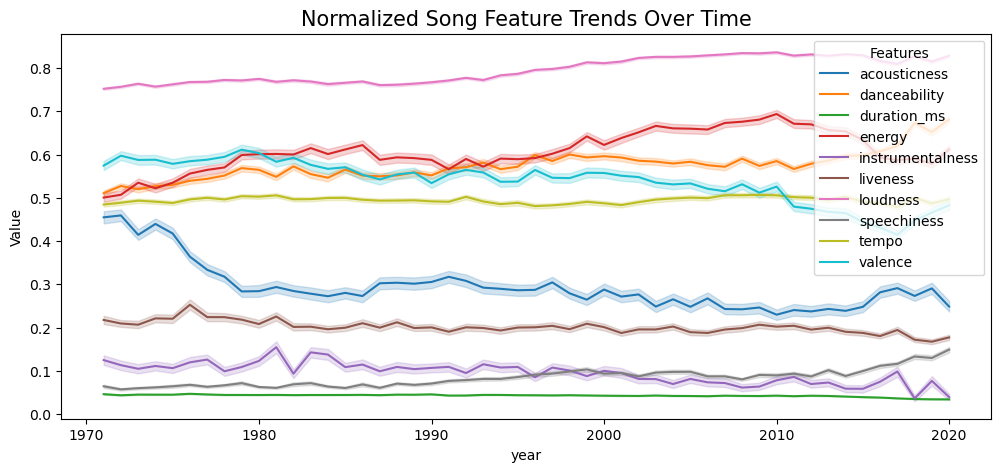

In [13]:
# Create a simple line plot for initial analysis
plt.figure(figsize=(12,5))
plt.title("Normalized Song Feature Trends Over Time", fontdict={"fontsize": 15})

lines = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
        'liveness', 'loudness', 'speechiness', 'tempo', 'valence']

for line in lines:
    sns.lineplot(x='year', y=line, data=df, label=line)
    
plt.ylabel("Value")
plt.legend(title="Features")
plt.show()

In [14]:
# Popular songs data
popular_df = df[df['popularity'] >= 50]
popular_df.shape

(36993, 19)

In [15]:
# Unpopular songs data
unpopular_df = df[df['popularity'] < 50]
unpopular_df.shape

(62663, 19)

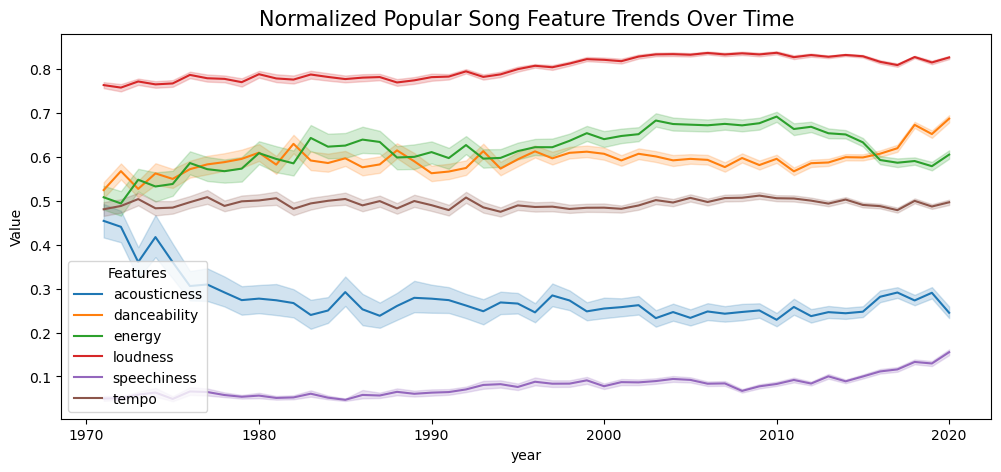

In [16]:
# Visualize popular songs df feature trends over time
plt.figure(figsize=(12, 5))
plt.title("Normalized Popular Song Feature Trends Over Time", fontdict={"fontsize": 15})

lines = ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo']

for line in lines:
    sns.lineplot(x='year', y=line, data=popular_df, label=line)
    
plt.ylabel("Value")
plt.legend(title="Features")
plt.show()

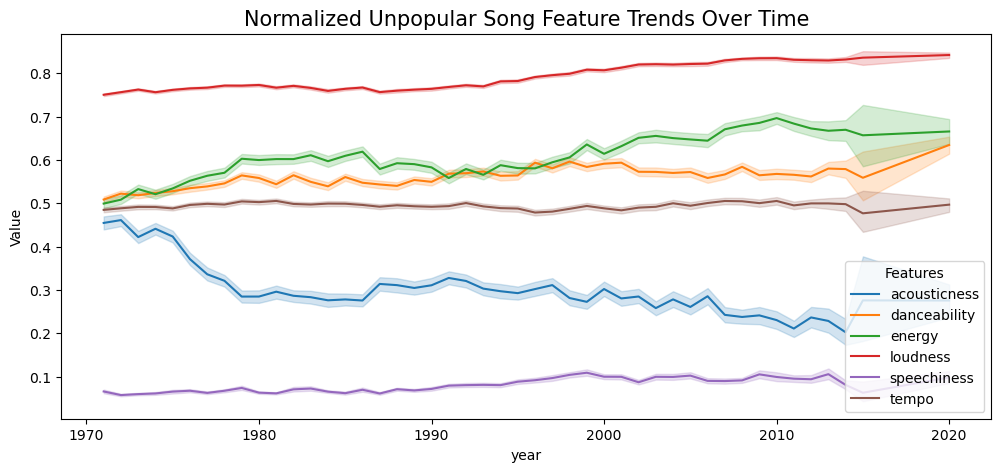

In [17]:
# Visualize unpopular songs df feature trends over time
plt.figure(figsize=(12, 5))
plt.title("Normalized Unpopular Song Feature Trends Over Time", fontdict={"fontsize": 15})

lines = ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo']

for line in lines:
    sns.lineplot(x='year', y=line, data=unpopular_df, label=line)
    
plt.ylabel("Value")
plt.legend(title="Features")
plt.show()

There is clearly a difference between popular and unpopular song features over time. Before the 1970s, popular songs had more variations in the six features: acousticness, danceability, energy, loudness, speechiness, and tempo. On the other hand, unpopular songs had less variation, indicating that their style stay relatively stagnant. After the 1970s, both unpopular and popular songs' features become relatively stable over time.

We want to predict future popular songs' feature trends.

In [18]:
df_popular = popular_df[['year', 'acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo', 'popularity']]
df_unpopular = unpopular_df[['year', 'acousticness', 'danceability', 'energy', 'loudness', 'speechiness', 'tempo', 'popularity']]

In [19]:
df_popular['year'] = pd.to_datetime(df_popular['year'], format='%Y')
df_unpopular['year'] = pd.to_datetime(df_unpopular['year'], format='%Y')

# Set 'year' as the index
df_popular.set_index('year', inplace=True)
df_unpopular.set_index('year', inplace=True)

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/2827517493.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_popular['year'] = pd.to_datetime(df_popular['year'], format='%Y')
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/2827517493.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unpopular['year'] = pd.to_datetime(df_unpopular['year'], format='%Y')


In [20]:
df_popular.head()

,acousticness,danceability,energy,loudness,speechiness,tempo,popularity
year,,,,,,,
1971-01-01,0.855422,0.474696,0.249,0.757844,0.031328,0.329099,52
1971-01-01,0.038956,0.652834,0.653,0.791039,0.025830,0.446010,54
1971-01-01,0.149598,0.383603,0.611,0.847970,0.033195,0.750241,54
1971-01-01,0.242972,0.358300,0.528,0.794145,0.043361,0.583823,56
1971-01-01,0.492972,0.502024,0.437,0.743443,0.035788,0.381325,55


## Baseline ARIMA
### Popular: Acousticness

In [33]:
acous_df = df_popular['acousticness']
acous_df = acous_df.resample('Y').mean()
acous_df.head()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/2082910502.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  acous_df = acous_df.resample('Y').mean()


year
1971-12-31    0.454244
1972-12-31    0.440739
1973-12-31    0.360485
1974-12-31    0.417329
1975-12-31    0.360256
Freq: YE-DEC, Name: acousticness, dtype: float64

In [34]:
acous_df.describe(include='all')

count    50.000000
mean      0.276159
std       0.049475
min       0.228978
25%       0.246937
50%       0.261848
75%       0.280811
max       0.454244
Name: acousticness, dtype: float64

In [35]:
acous_df.dropna(inplace=True)

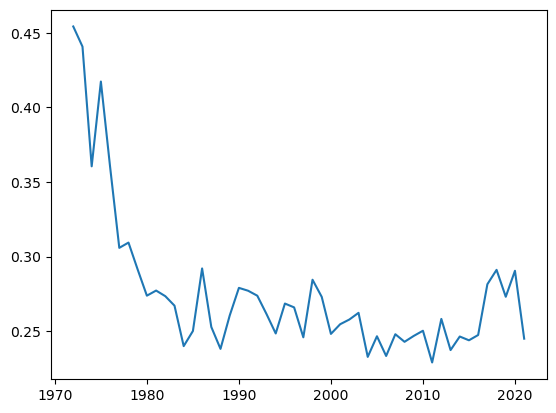

In [36]:
plt.plot(acous_df)

In [37]:
train, test = train_test_split(acous_df)

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


In [38]:
# Test if the process is stationary
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -3.9025049864467602
p-value: 0.002016488933801671


Since the p-value is less than 0.05, this process is stationary. We don't need differencing in the ARIMA model.

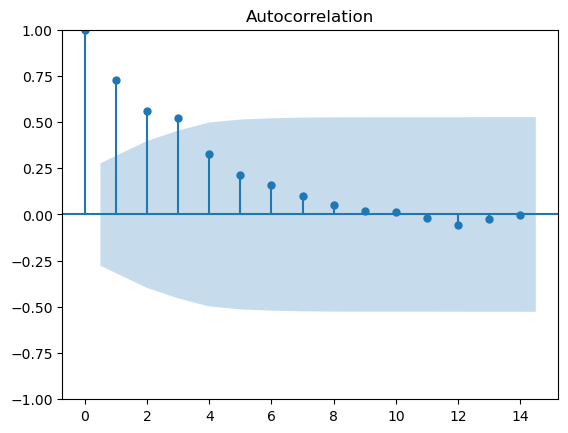

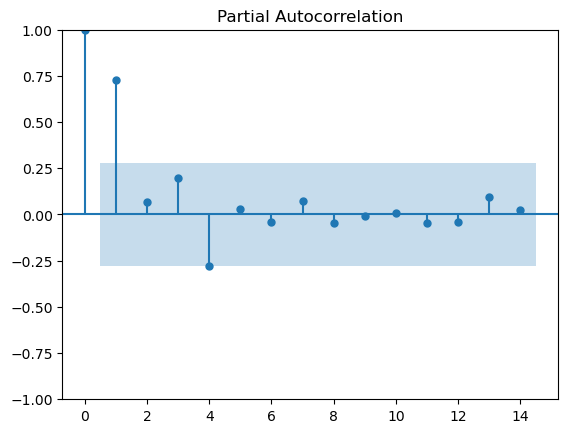

In [39]:
# ACF and PACF plots to determine p and q

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF and PACF plots
plot_acf(acous_df, lags=np.floor(len(train)/2))
plot_pacf(acous_df, lags=np.floor(len(train)/2))
plt.show()

In [40]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


model = ARIMA(train, order=(2, 0, 3))
# model = SARIMAX(train, order=(2, 0, 3), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

# Print summary
print(model_fit.summary())

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           acousticness   No. Observations:                   29
Model:                 ARIMA(2, 0, 3)   Log Likelihood                  65.575
Date:                Fri, 06 Dec 2024   AIC                           -117.150
Time:                        15:35:10   BIC                           -107.579
Sample:                    12-31-1971   HQIC                          -114.153
                         - 12-31-1999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3230      0.061      5.306      0.000       0.204       0.442
ar.L1          0.9000      0.287      3.140      0.002       0.338       1.462
ar.L2          0.0041      0.308      0.013      0.9

In [41]:
import itertools
from sklearn.metrics import mean_squared_error

# Define a range of values for p and q
p = q = range(0, 4)  # Test values from 0 to 3
d = 0  # Since the series is stationary
pdq = list(itertools.product(p, [d], q))

# Grid search to find the best combination of p, d, q
best_aic = float("inf")
best_order = None
best_model = None

for order in pdq:
    try:
        model = ARIMA(acous_df, order=order)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_order = order
            best_model = model_fit
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")


/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/p

Best ARIMA order: (2, 0, 3) with AIC: -220.52611639998725


/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RMSE: 0.018799217075479123


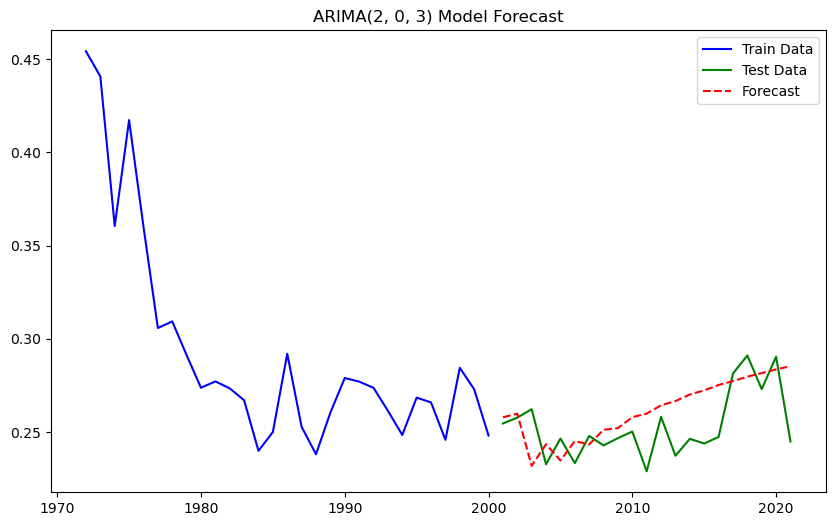

In [42]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate RMSE
rmse = mean_squared_error(test, forecast, squared=False)
print(f'RMSE: {rmse}')

# Plot
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train Data', color='blue')
plt.plot(test, label='Test Data', color='green')
plt.plot(test.index, forecast, label='Forecast', linestyle='--', color='red')
plt.title('ARIMA(2, 0, 3) Model Forecast')
plt.legend()
plt.show()


RMSE: 0.018799217075479123


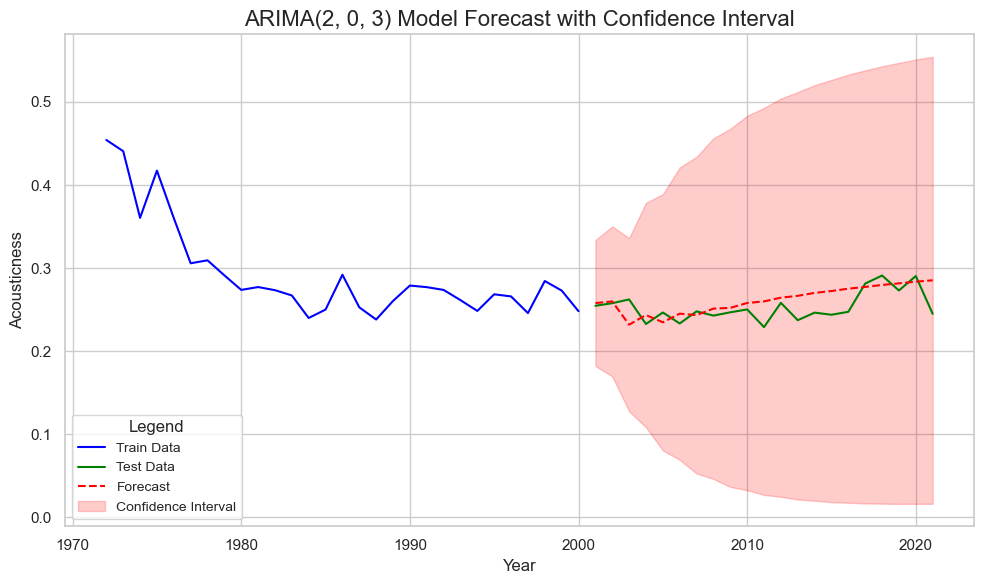

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error

# Forecast and confidence intervals
forecast = model_fit.forecast(steps=len(test))
forecast = forecast.flatten() if forecast.ndim > 1 else forecast  # Ensure 1D

# Get confidence intervals
conf_int = model_fit.get_forecast(steps=len(test)).conf_int(alpha=0.001)

# Evaluate RMSE
rmse = mean_squared_error(test, forecast, squared=False)
print(f'RMSE: {rmse}')

# Plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot train data
sns.lineplot(x=train.index, y=train.values, label='Train Data', color='blue')

# Plot test data
sns.lineplot(x=test.index, y=test.values, label='Test Data', color='green')

# Plot forecast
sns.lineplot(x=test.index, y=forecast, label='Forecast', color='red', linestyle='--')

# Add confidence intervals as shaded regions
plt.fill_between(
    test.index,
    conf_int['lower acousticness'],
    conf_int['upper acousticness'],
    color="red",
    alpha=0.2,
    label="Confidence Interval",
)

# Add titles and labels
plt.title('ARIMA(2, 0, 3) Model Forecast with Confidence Interval', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Acousticness', fontsize=12)
plt.legend(title="Legend", fontsize=10)
plt.tight_layout()
plt.show()


In [55]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

def time_series_analysis(train, test):
    """
    Performs ARIMA time series analysis, including model selection, fitting, and forecasting.

    Parameters:
        train (pd.DataFrame): The training dataset (time series).
        test (pd.DataFrame): The testing dataset (time series).

    Returns:
        dict: A dictionary containing the best model, forecast, RMSE, and plots.
    """
    # ADF Test for stationarity
    adf_result = adfuller(train)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])
    if result[1] < 0.05:
        print('Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.')
    else:
        print('Since the p-value is greater than 0.05, this process is not stationary. We need differencing in the ARIMA model.')


    # ACF and PACF plots
    plt.figure(figsize=(12, 6))
    plot_acf(train, lags=min(40, len(train)//2))
    plot_pacf(train, lags=min(40, len(train)//2))
    plt.show()

    # Grid search for best ARIMA parameters
    p = q = range(0, 4)
    d = 0  # Assumed stationary
    pdq = list(itertools.product(p, [d], q))

    best_aic = float("inf")
    best_order = None
    best_model = None

    for order in pdq:
        try:
            model = ARIMA(train, order=order)
            model_fit = model.fit()
            if model_fit.aic < best_aic:
                best_aic = model_fit.aic
                best_order = order
                best_model = model_fit
        except:
            continue

    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")

    # Forecast using the best model
    forecast = best_model.forecast(steps=len(test))
    forecast = forecast.flatten() if forecast.ndim > 1 else forecast

    # Get confidence intervals
    conf_int = best_model.get_forecast(steps=len(test)).conf_int()

    # Evaluate RMSE
    rmse = mean_squared_error(test, forecast, squared=False)
    # print(f'RMSE: {rmse}')

    # Plot the results
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))

    sns.lineplot(x=train.index, y=train.values, label='Train Data', color='blue')
    sns.lineplot(x=test.index, y=test.values, label='Test Data', color='green')
    sns.lineplot(x=test.index, y=forecast, label='Forecast', color='red', linestyle='--')

    plt.fill_between(
        test.index,
        conf_int.iloc[:, 0],
        conf_int.iloc[:, 1],
        color="red",
        alpha=0.2,
        label="Confidence Interval",
    )

    plt.title('ARIMA Model Forecast with Confidence Interval', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.legend(title="Legend", fontsize=10)
    plt.tight_layout()
    plt.show()

    # return {
    #     "best_model": best_model,
    #     "forecast": forecast,
    #     "rmse": rmse,
    #     "confidence_interval": conf_int
    # }


ADF Statistic: -3.9025049864467602
p-value: 0.002016488933801671
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


<Figure size 1200x600 with 0 Axes>

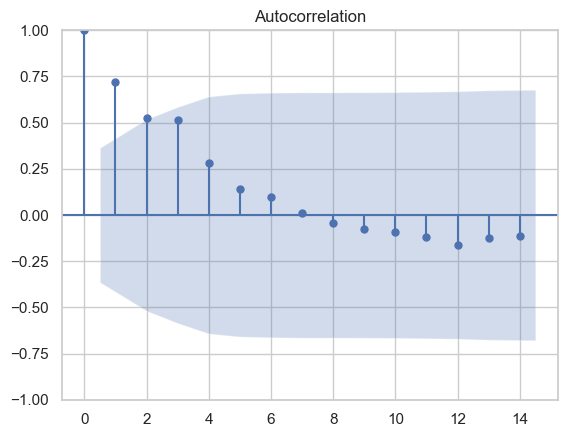

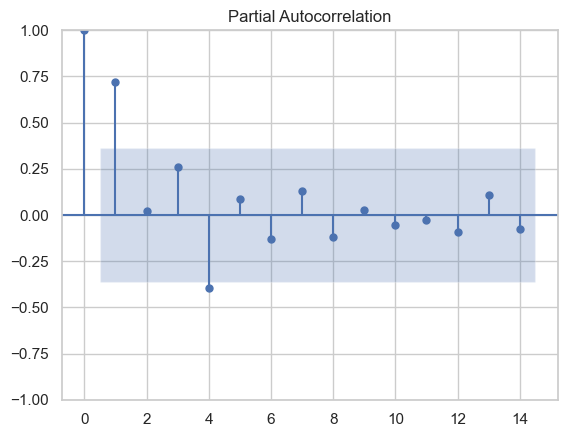

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-pa

Best ARIMA order: (1, 0, 3) with AIC: -119.1936063539319


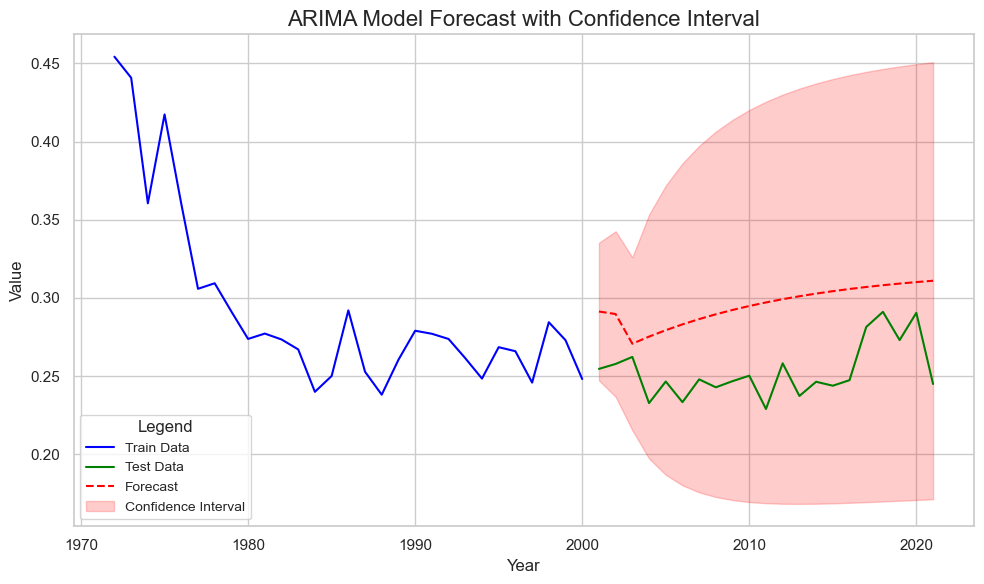

In [56]:
time_series_analysis(train, test)

### Popular: Energy

In [46]:
energy_df = df_popular['energy']
energy_df = energy_df.resample('Y').mean()
energy_df.head()

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/2187345849.py:2: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  energy_df = energy_df.resample('Y').mean()


year
1971-12-31    0.508010
1972-12-31    0.493979
1973-12-31    0.548034
1974-12-31    0.532608
1975-12-31    0.538312
Freq: YE-DEC, Name: energy, dtype: float64

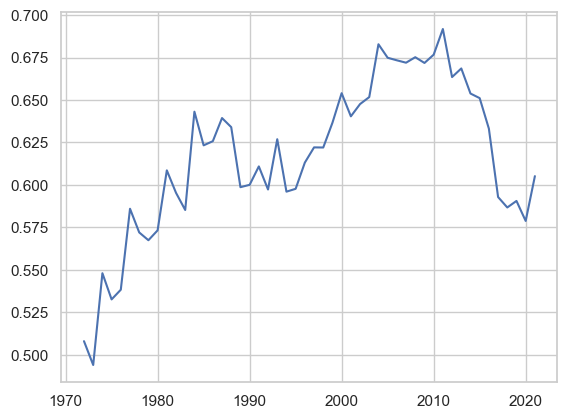

In [47]:
plt.plot(energy_df)

In [48]:
energy_train, energy_test = train_test_split(energy_df)

/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


ADF Statistic: -2.116994102994827
p-value: 0.23773631993480843


<Figure size 1200x600 with 0 Axes>

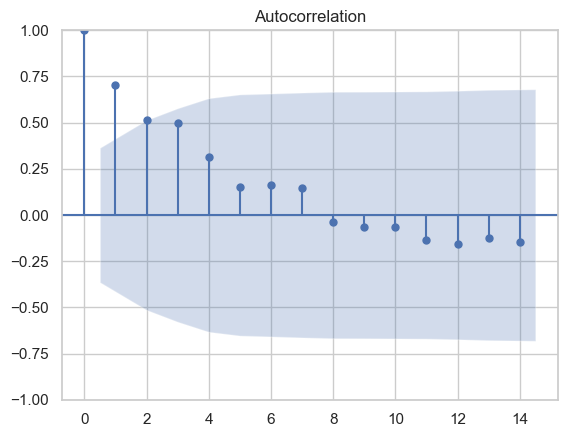

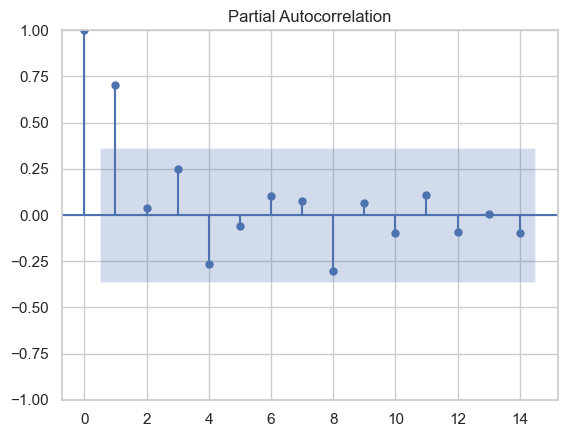

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/p

Best ARIMA order: (1, 0, 3) with AIC: -131.78706170028389


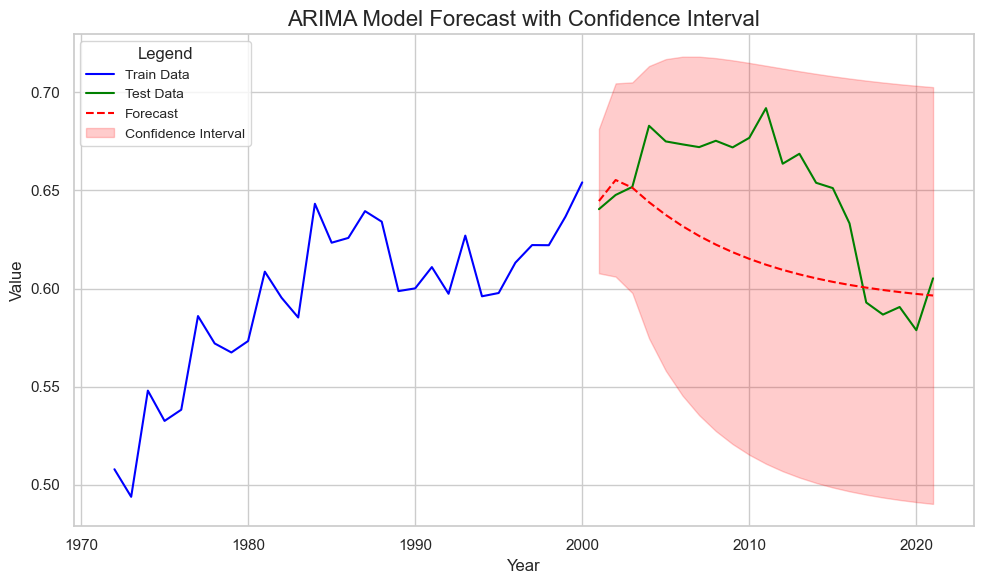

In [49]:
time_series_analysis(energy_train, energy_test)

### Pooular: features

In [50]:
df_popular.columns

Index(['acousticness', 'danceability', 'energy', 'loudness', 'speechiness',
       'tempo', 'popularity'],
      dtype='object')

danceability
count    50.000000
mean      0.593248
std       0.028876
min       0.524460
25%       0.577929
50%       0.592672
75%       0.607084
max       0.687082
Name: danceability, dtype: float64
ADF Statistic: -3.8004110522305754
p-value: 0.0029031121902214907
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/391875202.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pop_feat_df = pop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


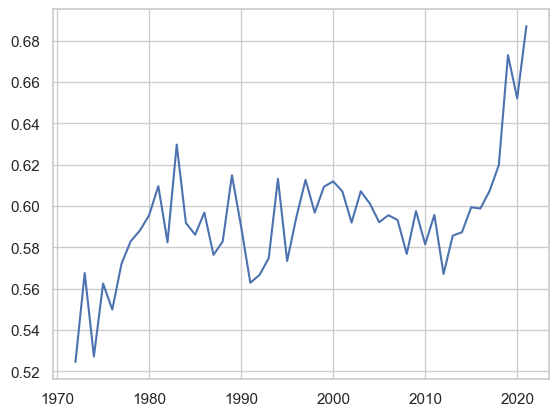

<Figure size 1200x600 with 0 Axes>

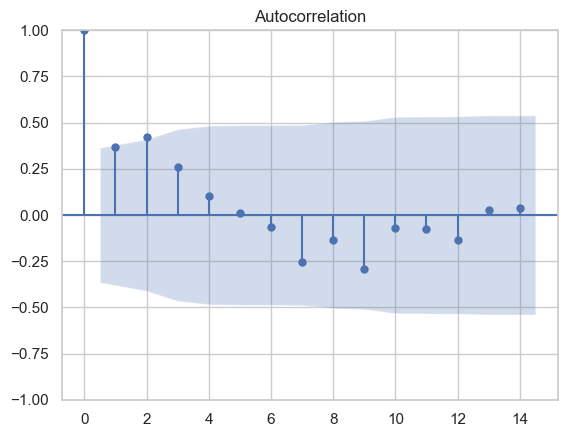

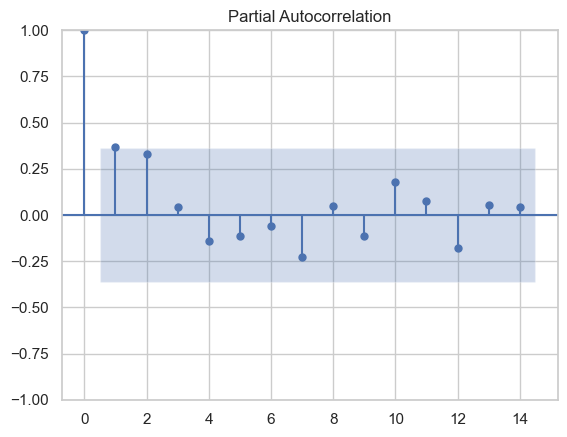

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/p

Best ARIMA order: (2, 0, 0) with AIC: -135.41697965155242


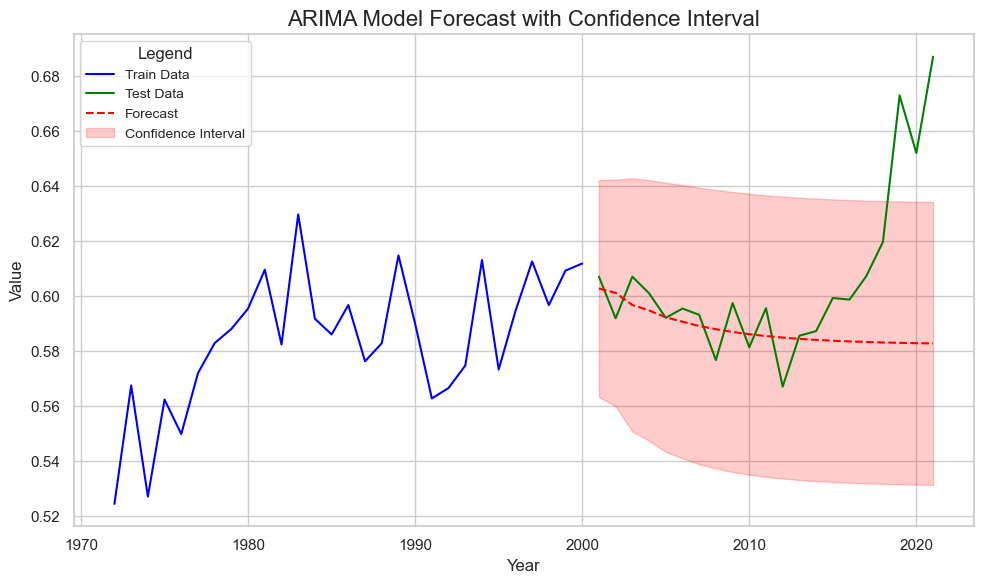

loudness
count    50.000000
mean      0.802001
std       0.025528
min       0.757839
25%       0.779488
50%       0.802010
75%       0.827888
max       0.837114
Name: loudness, dtype: float64
ADF Statistic: 0.9102264217346354
p-value: 0.9932223431220746
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/391875202.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pop_feat_df = pop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


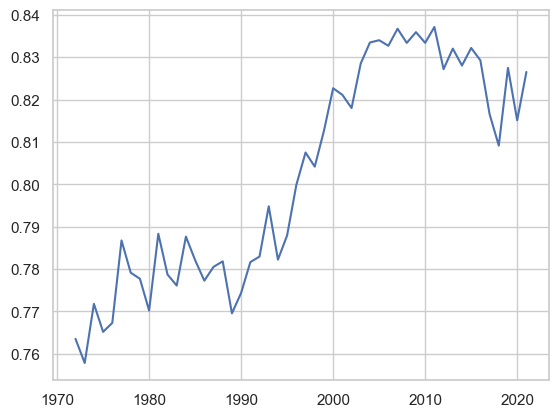

<Figure size 1200x600 with 0 Axes>

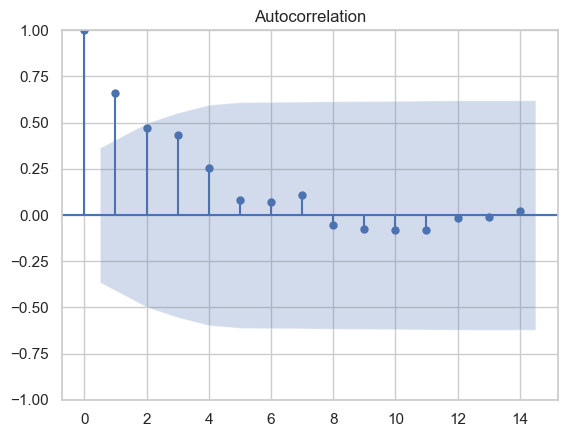

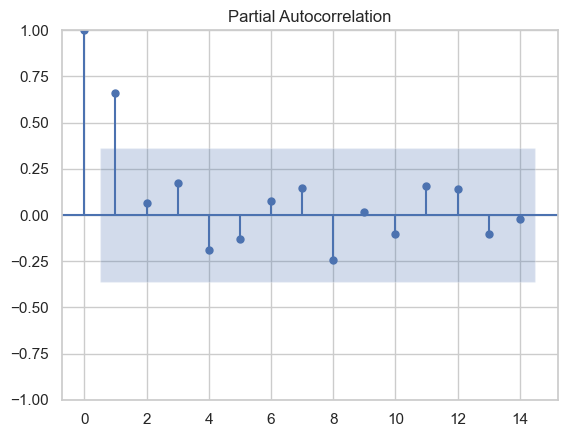

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-pa

Best ARIMA order: (1, 0, 1) with AIC: -183.6091188079047


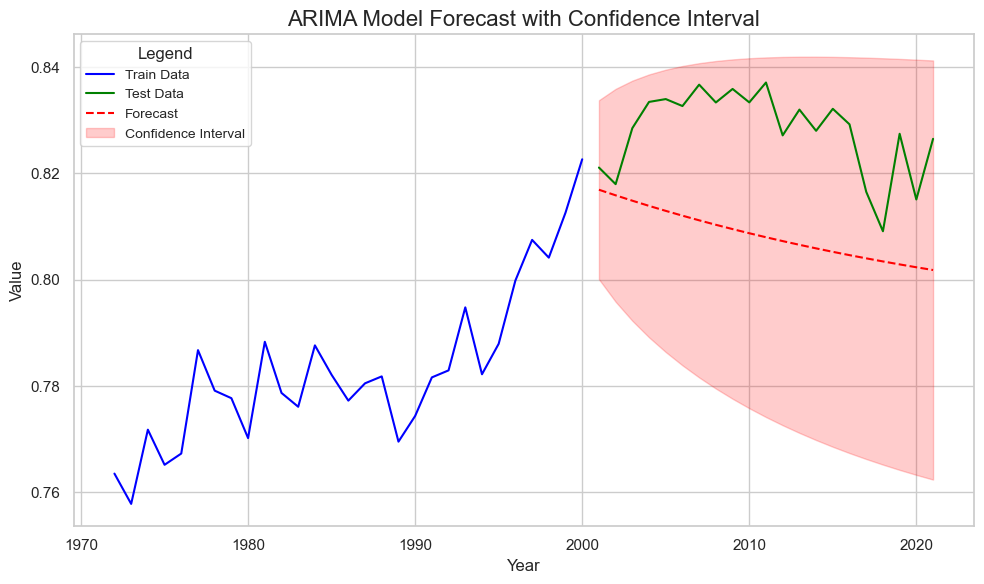

speechiness
count    50.000000
mean      0.077645
std       0.023401
min       0.046658
25%       0.058932
50%       0.077522
75%       0.088570
max       0.155175
Name: speechiness, dtype: float64
ADF Statistic: -1.3356034823414193
p-value: 0.6127304260491494
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/391875202.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pop_feat_df = pop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


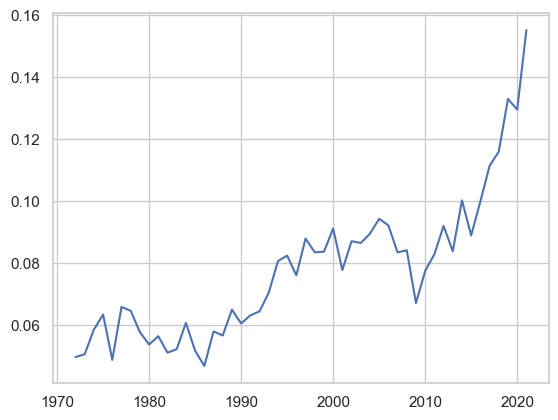

<Figure size 1200x600 with 0 Axes>

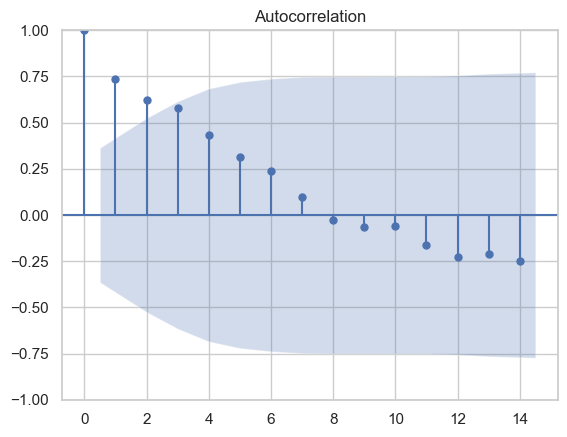

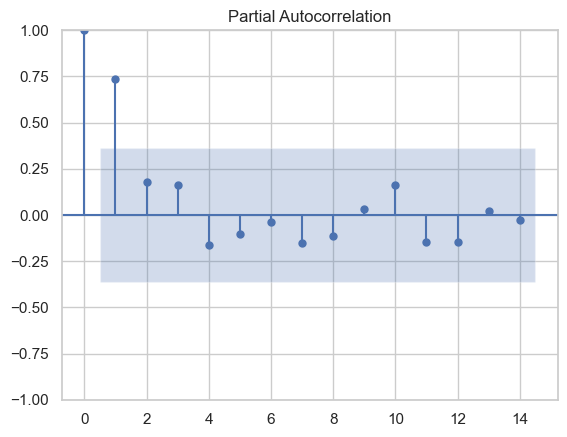

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt

Best ARIMA order: (1, 0, 3) with AIC: -198.01343785756816


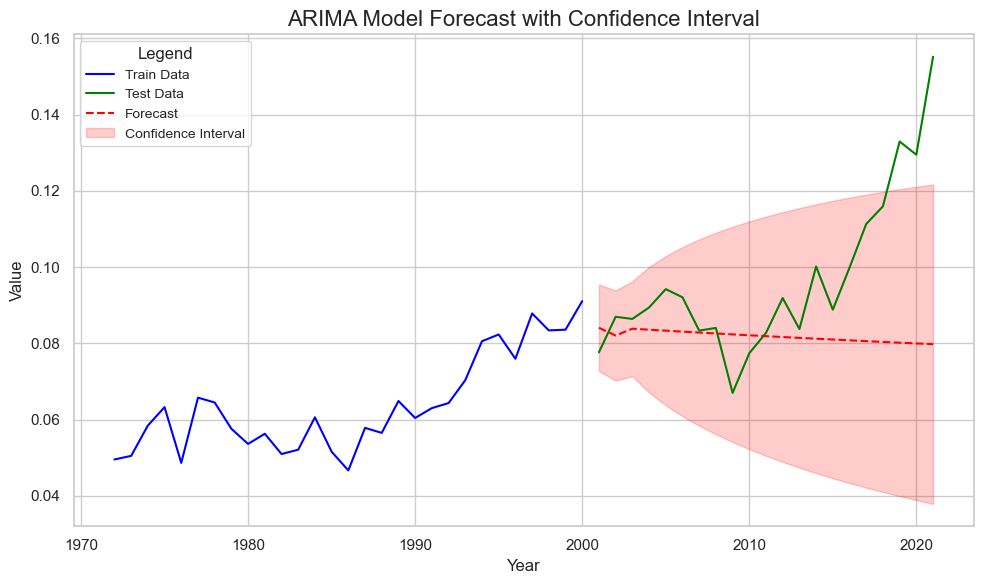

tempo
count    50.000000
mean      0.493690
std       0.009716
min       0.474972
25%       0.485267
50%       0.493832
75%       0.501378
max       0.511837
Name: tempo, dtype: float64
ADF Statistic: -5.358425955695511
p-value: 4.1391726566617555e-06
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/391875202.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pop_feat_df = pop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


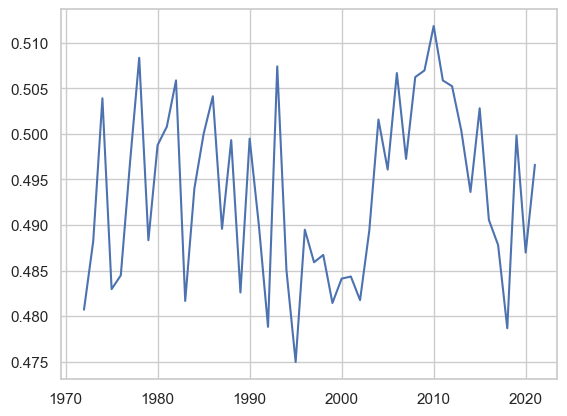

<Figure size 1200x600 with 0 Axes>

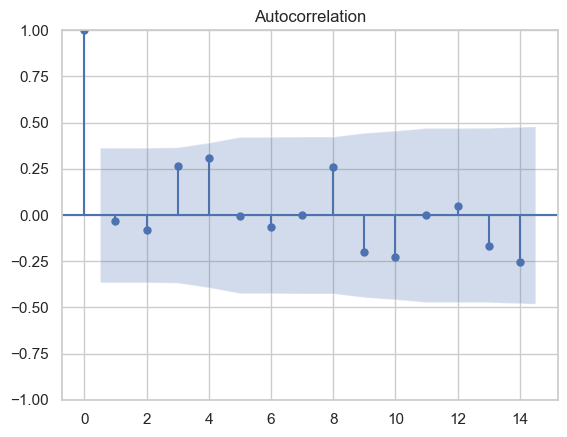

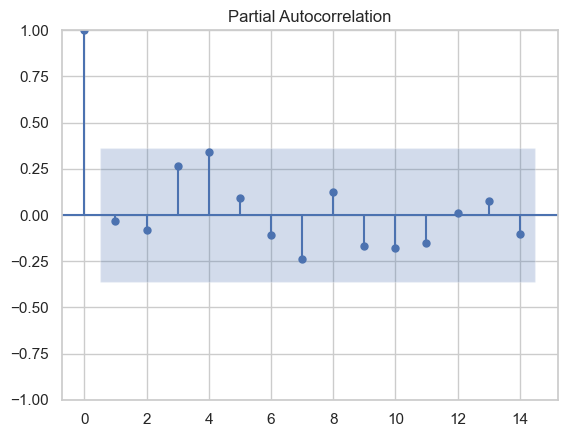

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1

Best ARIMA order: (0, 0, 0) with AIC: -184.44132054036092


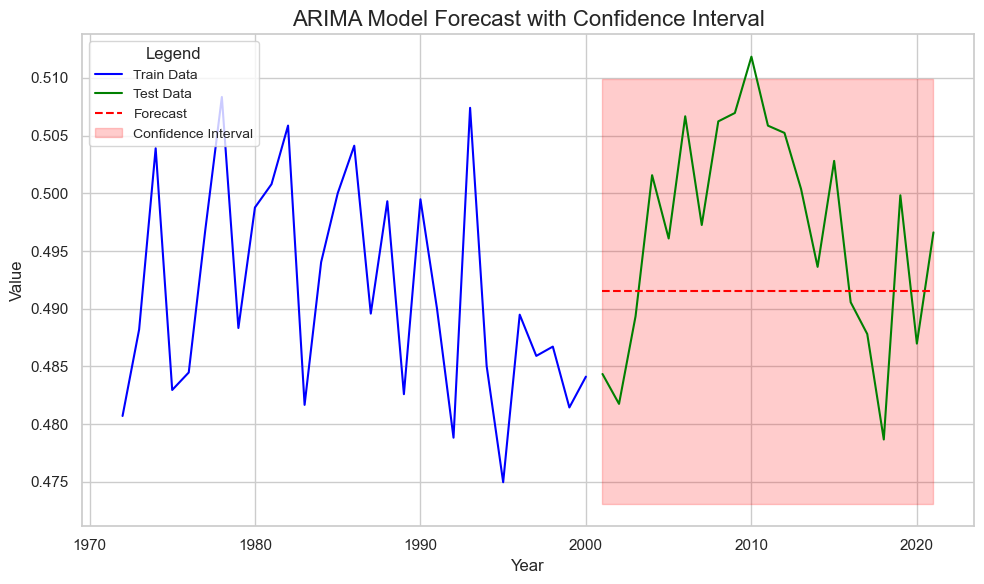

popularity
count    50.000000
mean     58.275998
std       3.053469
min      56.271642
25%      57.050616
50%      57.259418
75%      57.817549
max      70.044843
Name: popularity, dtype: float64
ADF Statistic: -3.7066987155124487
p-value: 0.004019911273346396
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/391875202.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  pop_feat_df = pop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


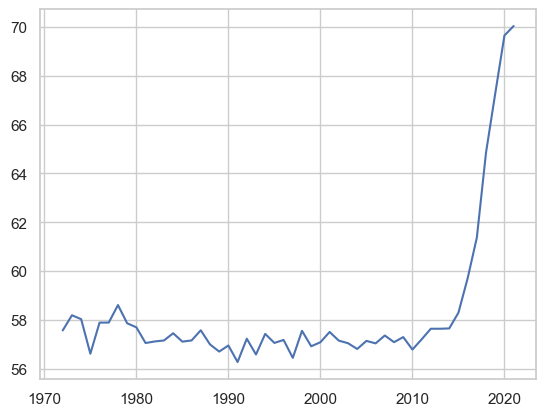

<Figure size 1200x600 with 0 Axes>

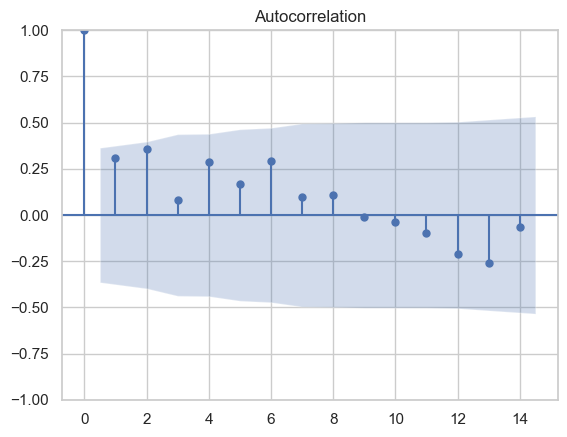

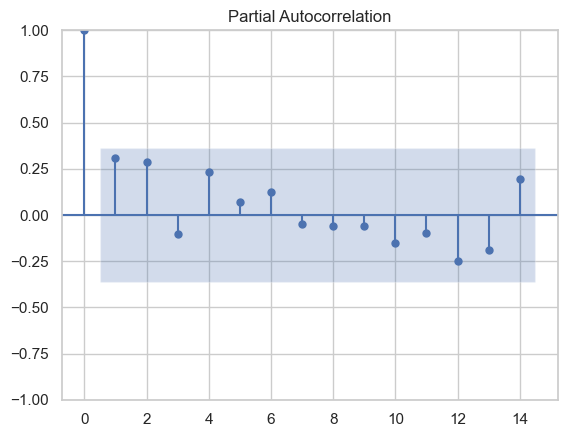

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/st

Best ARIMA order: (2, 0, 0) with AIC: 48.039197995557366


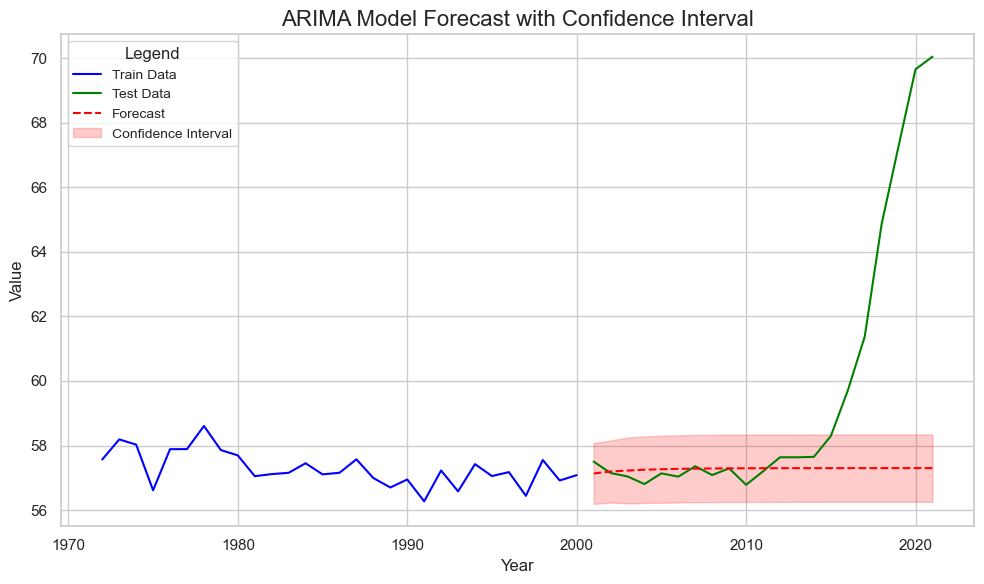

In [59]:
pop_feats = ['danceability', 'loudness', 'speechiness', 'tempo', 'popularity']
for pop_feat in pop_feats:
    print(pop_feat)
    pop_feat_df = df_popular[pop_feat]
    pop_feat_df = pop_feat_df.resample('Y').mean()
    pop_feat_df.dropna(inplace=True)
    plt.plot(pop_feat_df)

    print(pop_feat_df.describe(include='all'))

    pop_feat_train, pop_feat_test = train_test_split(pop_feat_df)
    time_series_analysis(pop_feat_train, pop_feat_test)

### Unpopular: features

In [58]:
df_unpopular.columns

Index(['acousticness', 'danceability', 'energy', 'loudness', 'speechiness',
       'tempo', 'popularity'],
      dtype='object')

acousticness
count    46.000000
mean      0.299683
std       0.059634
min       0.202593
25%       0.275791
50%       0.285379
75%       0.311369
max       0.461355
Name: acousticness, dtype: float64
ADF Statistic: -2.2492221696083408
p-value: 0.18886782631108406
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/1487284144.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  unpop_feat_df = unpop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


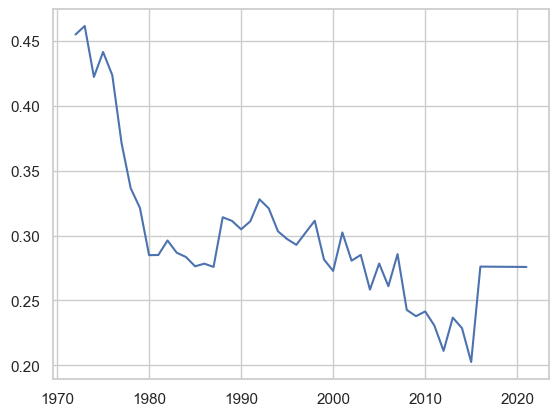

<Figure size 1200x600 with 0 Axes>

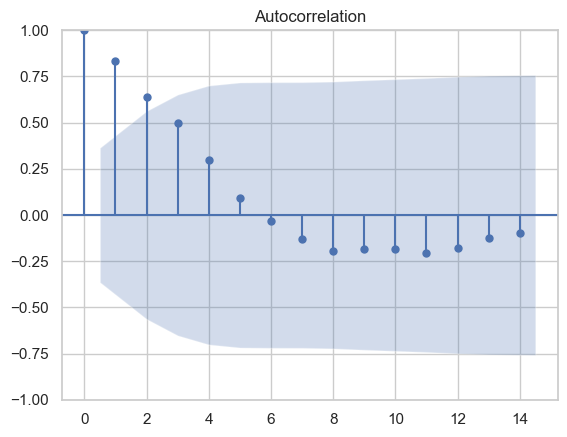

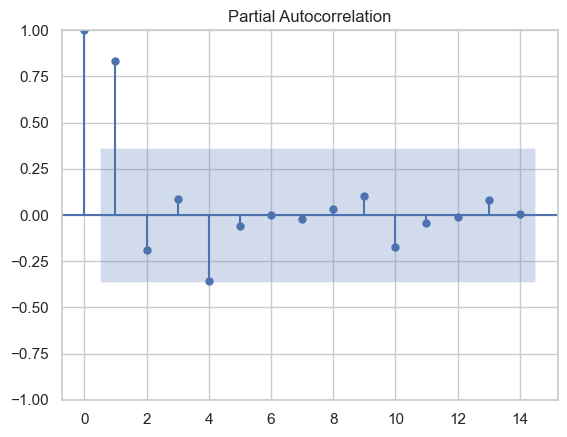

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anacond

Best ARIMA order: (1, 0, 0) with AIC: -135.5615443674476


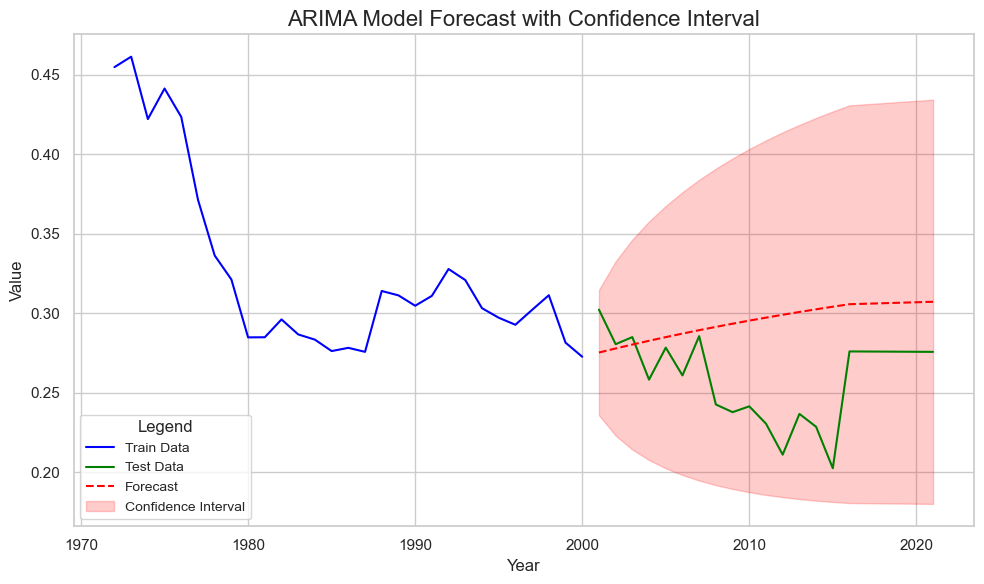

danceability
count    46.000000
mean      0.561465
std       0.023414
min       0.508764
25%       0.546410
50%       0.564351
75%       0.572732
max       0.634589
Name: danceability, dtype: float64
ADF Statistic: -0.9540187117267604
p-value: 0.7696635263744277
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/1487284144.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  unpop_feat_df = unpop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


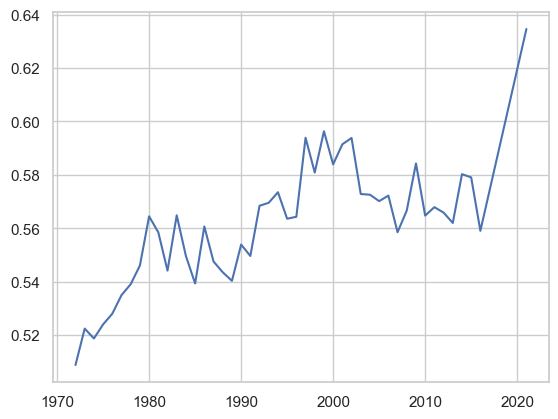

<Figure size 1200x600 with 0 Axes>

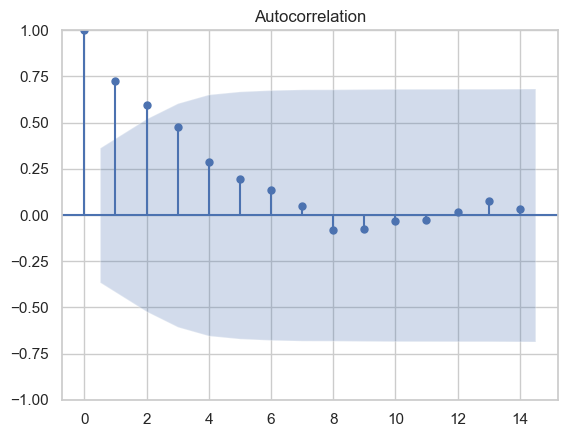

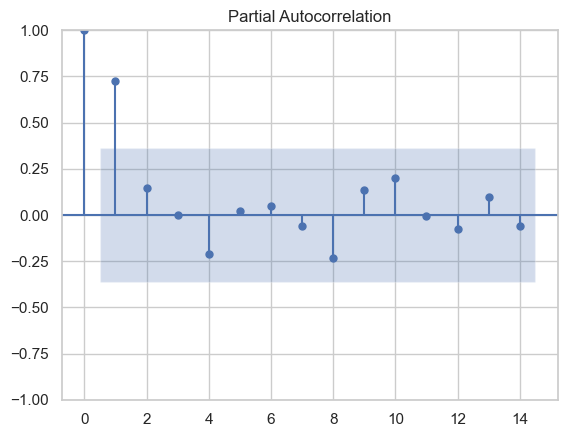

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/p

Best ARIMA order: (2, 0, 0) with AIC: -166.45450665669267


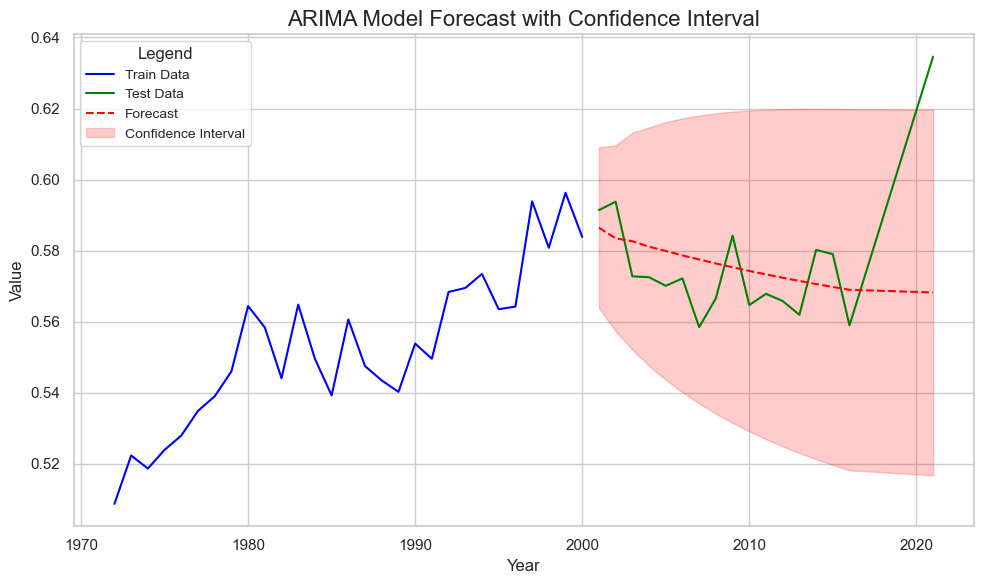

energy
count    46.000000
mean      0.608812
std       0.049993
min       0.499420
25%       0.579630
50%       0.602489
75%       0.650962
max       0.696646
Name: energy, dtype: float64
ADF Statistic: -1.9666520373345786
p-value: 0.30138364913122484
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/1487284144.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  unpop_feat_df = unpop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


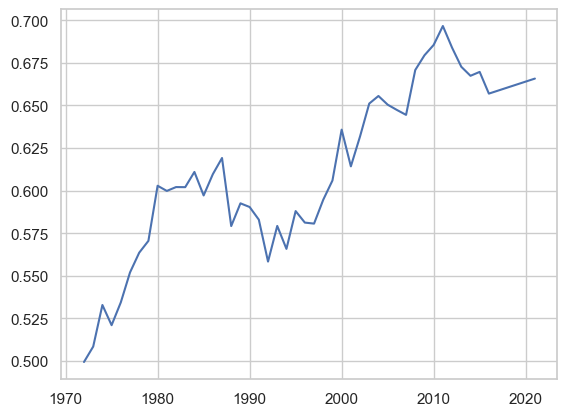

<Figure size 1200x600 with 0 Axes>

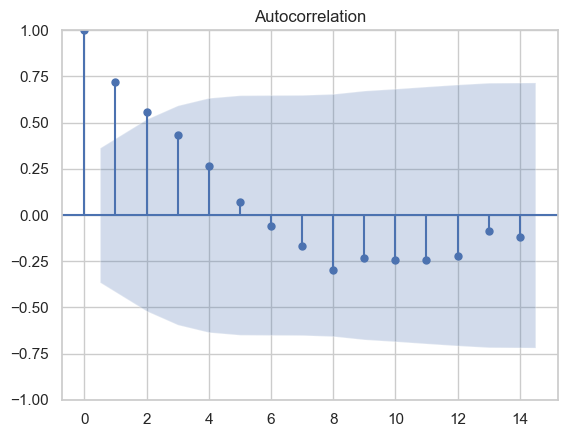

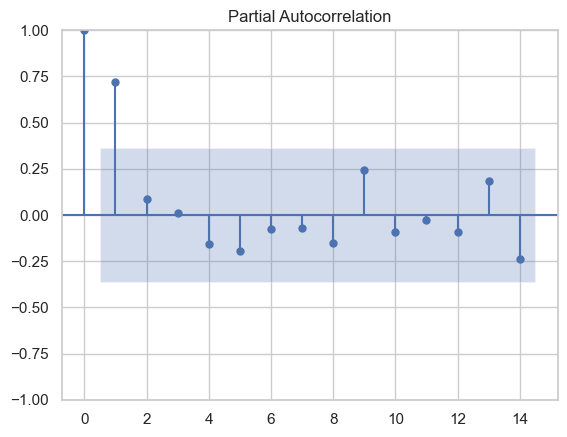

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt

Best ARIMA order: (2, 0, 3) with AIC: -149.58049309467418


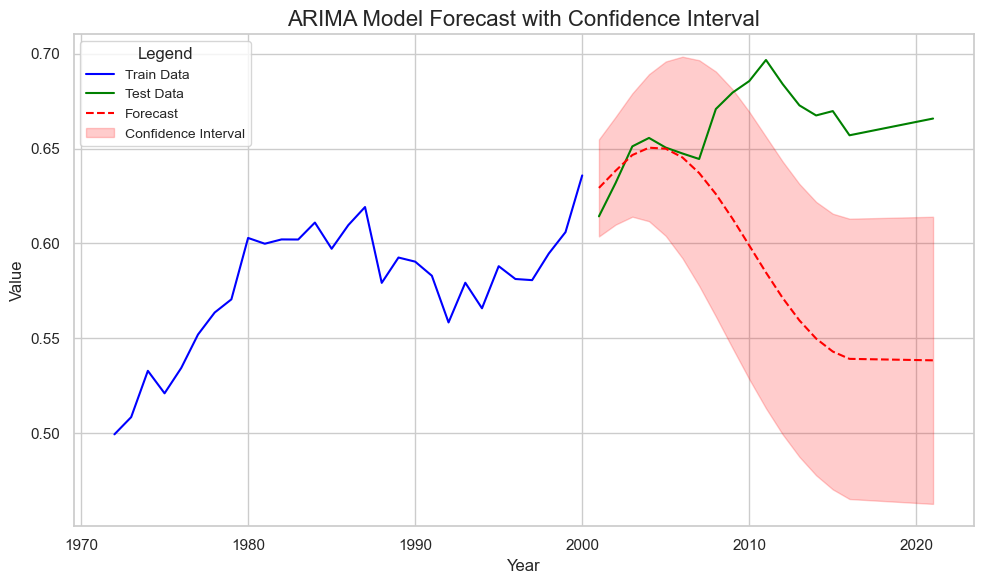

loudness
count    46.000000
mean      0.791283
std       0.030106
min       0.750450
25%       0.765400
50%       0.777192
75%       0.821282
max       0.842104
Name: loudness, dtype: float64
ADF Statistic: 0.5392784045206432
p-value: 0.9860192833531914
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/1487284144.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  unpop_feat_df = unpop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


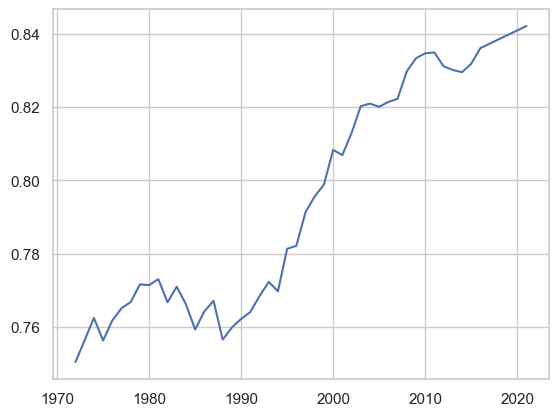

<Figure size 1200x600 with 0 Axes>

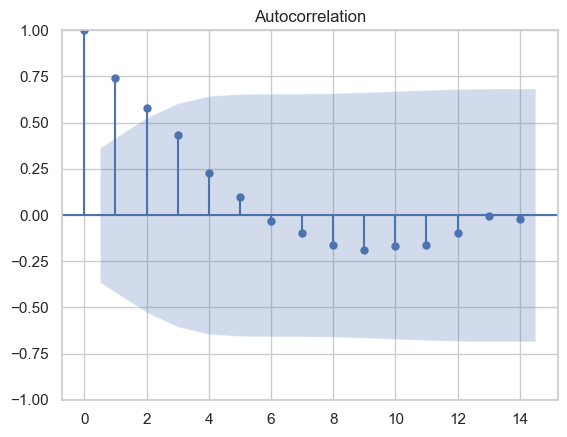

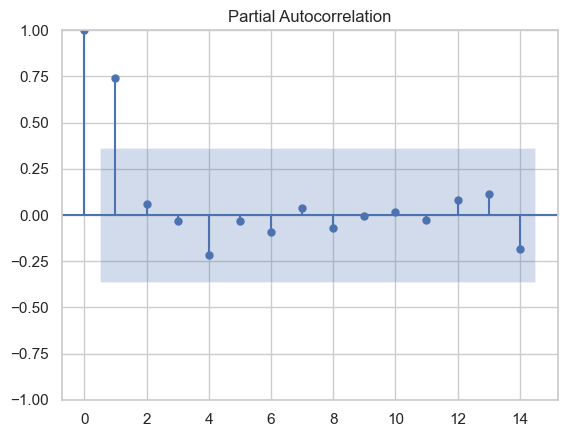

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1

Best ARIMA order: (1, 0, 3) with AIC: -210.78689657684805


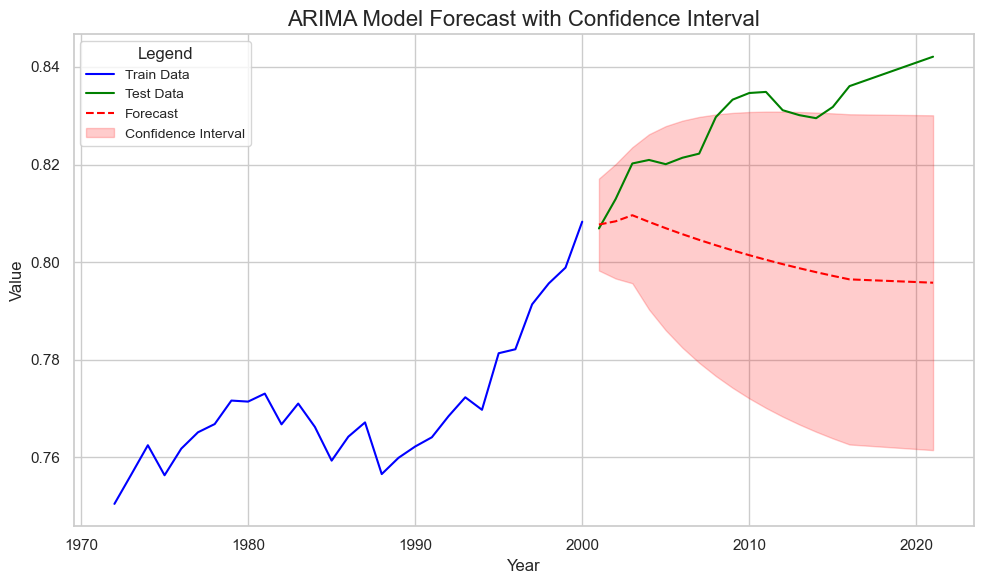

speechiness
count    46.000000
mean      0.081270
std       0.015921
min       0.057687
25%       0.066410
50%       0.080606
75%       0.096573
max       0.109224
Name: speechiness, dtype: float64
ADF Statistic: 2.529858343463098
p-value: 0.9990588504854714
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/1487284144.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  unpop_feat_df = unpop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


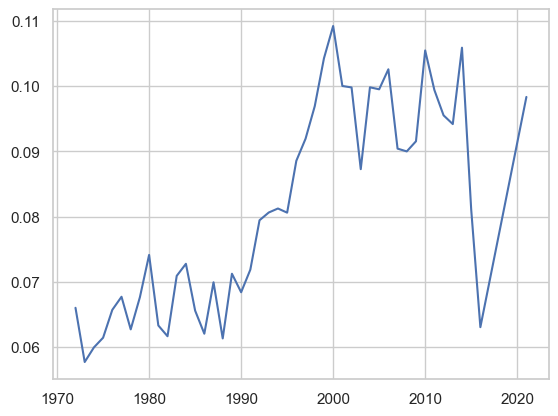

<Figure size 1200x600 with 0 Axes>

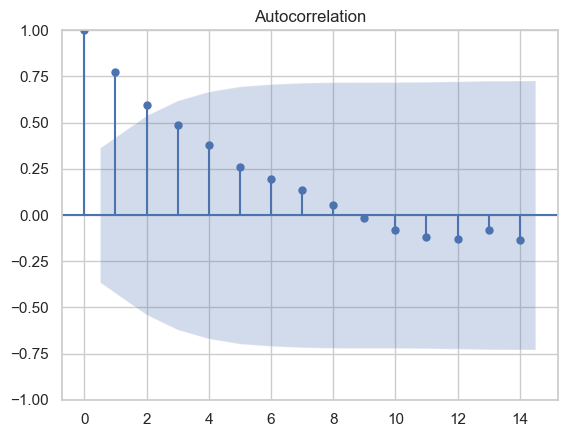

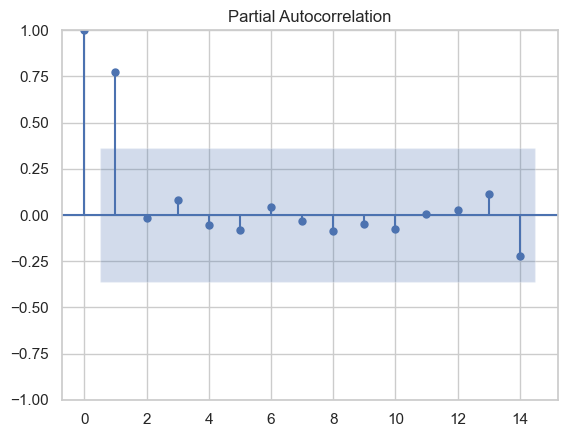

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autor

Best ARIMA order: (1, 0, 0) with AIC: -208.1405228999556


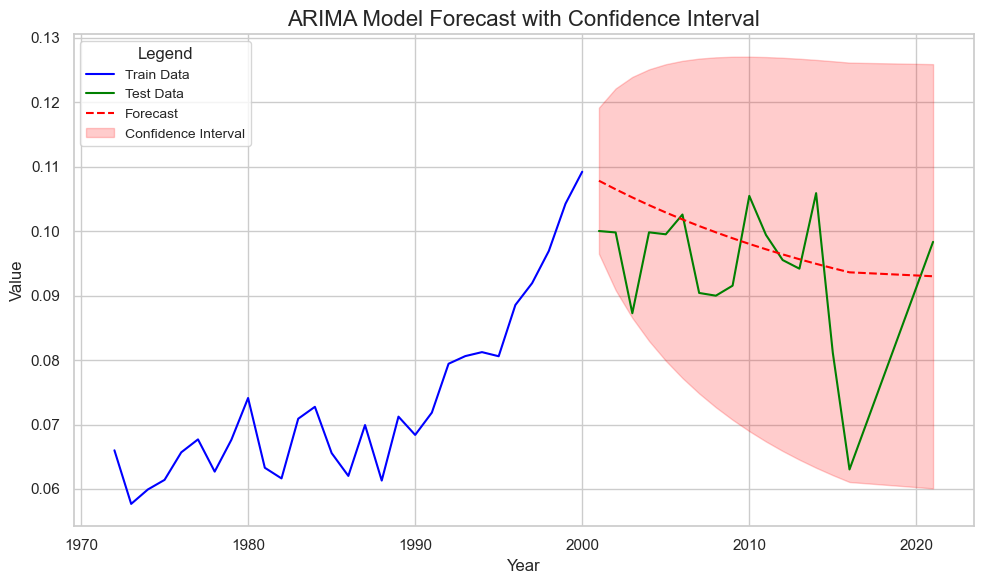

tempo
count    46.000000
mean      0.494614
std       0.006985
min       0.476955
25%       0.490466
50%       0.495421
75%       0.499720
max       0.505535
Name: tempo, dtype: float64
ADF Statistic: -2.217032334122513
p-value: 0.20012187888656496
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/1487284144.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  unpop_feat_df = unpop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


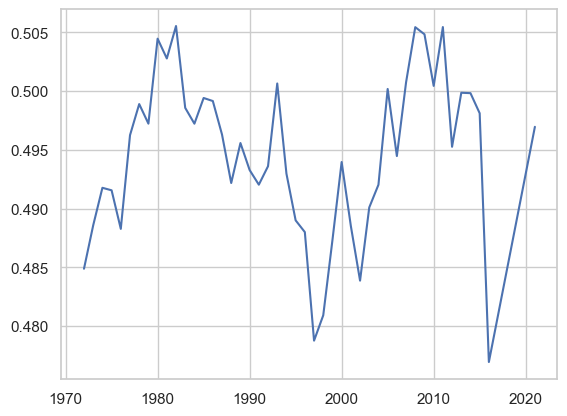

<Figure size 1200x600 with 0 Axes>

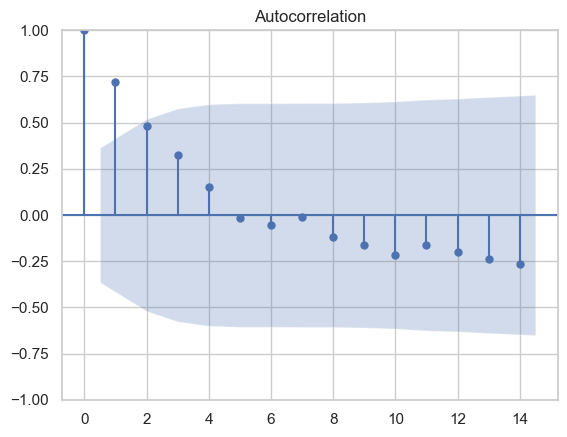

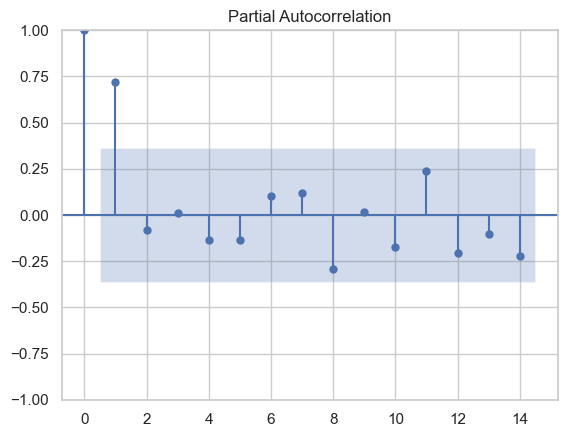

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/st

Best ARIMA order: (1, 0, 0) with AIC: -228.0661014098292


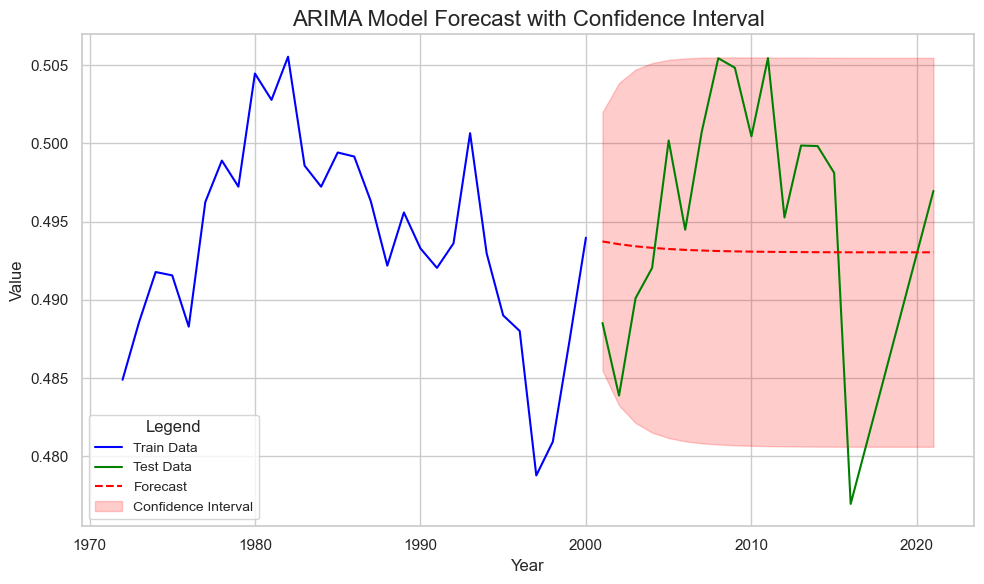

popularity
count    46.000000
mean     38.022132
std       7.117660
min       7.605128
25%      32.948837
50%      38.506374
75%      43.187038
max      48.888889
Name: popularity, dtype: float64
ADF Statistic: -0.13139006166574757
p-value: 0.9462208107012957
Since the p-value is less than 0.05, this process is stationary. We do not need differencing in the ARIMA model.


/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/1487284144.py:6: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  unpop_feat_df = unpop_feat_df.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  train = train.resample('Y').mean()
/var/folders/sv/tqkwxbbd1l96g8tr45l86pmw0000gn/T/ipykernel_82643/3269961136.py:9: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  test = test.resample('Y').mean()


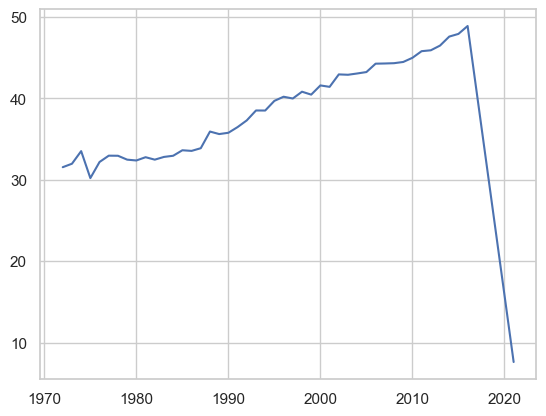

<Figure size 1200x600 with 0 Axes>

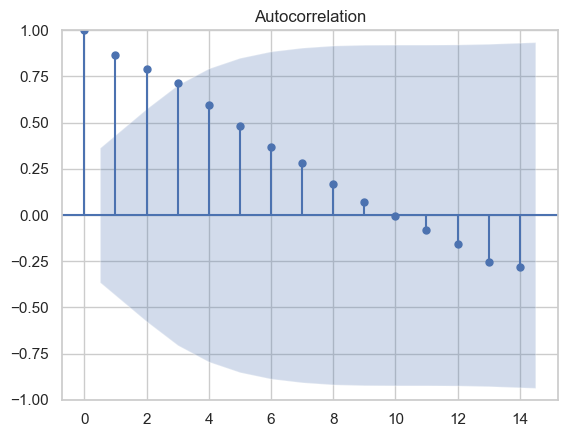

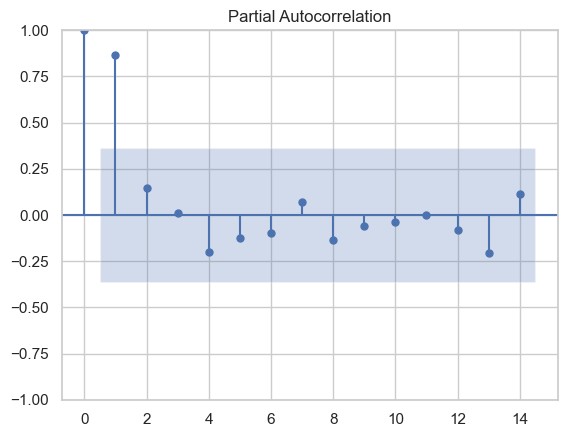

/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/anaconda3/envs/1018/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive paramet

Best ARIMA order: (2, 0, 2) with AIC: 86.2954769786361


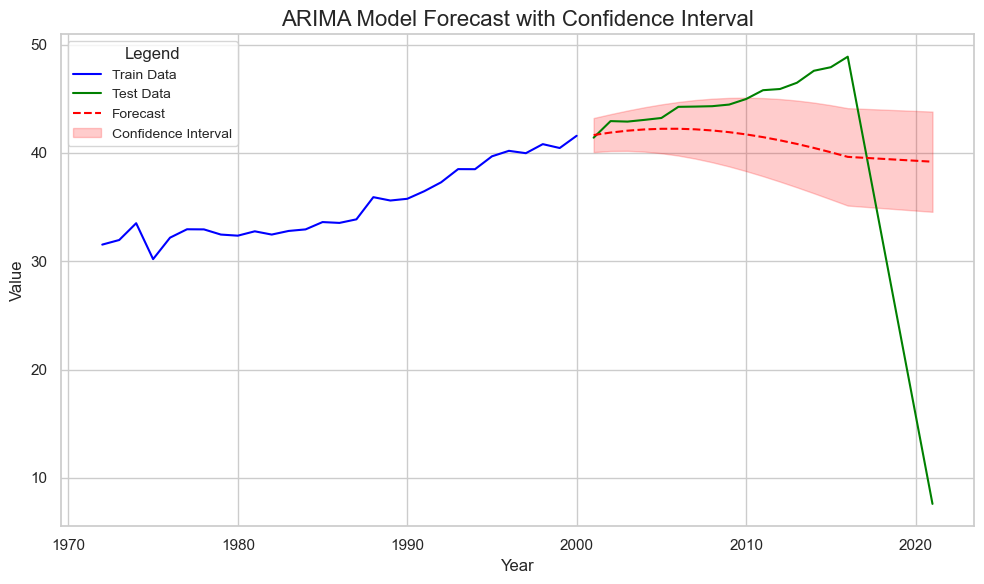

In [60]:
unpop_feats = ['acousticness', 'danceability', 'energy', 'loudness', 'speechiness',
       'tempo', 'popularity']
for unpop_feat in unpop_feats:
    print(unpop_feat)
    unpop_feat_df = df_unpopular[unpop_feat]
    unpop_feat_df = unpop_feat_df.resample('Y').mean()
    unpop_feat_df.dropna(inplace=True)
    plt.plot(unpop_feat_df)

    print(unpop_feat_df.describe(include='all'))

    unpop_feat_train, unpop_feat_test = train_test_split(unpop_feat_df)
    time_series_analysis(unpop_feat_train, unpop_feat_test)